# Convolutional Neural Network

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

## Data Paths

In [3]:
train_path = 'archive/seg_train/seg_train/'
test_path = 'archive/seg_test/seg_test/'

## Load Data

In [4]:
image_size = (150, 150) # 150x150 pixels

def load_images(path):
    X = []
    y = []

    folders = sorted(os.listdir(path), key=lambda x: os.path.getmtime(os.path.join(path, x)))

    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(i)

    return np.array(X), np.array(y)

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

## Number of Classes

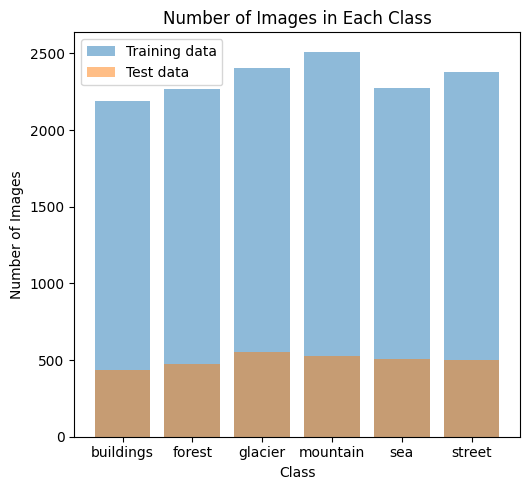

In [5]:
# plot the number if images in each class in the training and test data
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(*np.unique(y_train, return_counts=True), label='Training data', alpha=0.5)
plt.bar(*np.unique(y_test, return_counts=True), label='Test data', alpha=0.5)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(labels)), labels.values())  # Set the x-axis tick labels
plt.legend()
plt.tight_layout()
plt.show()


## Show Data

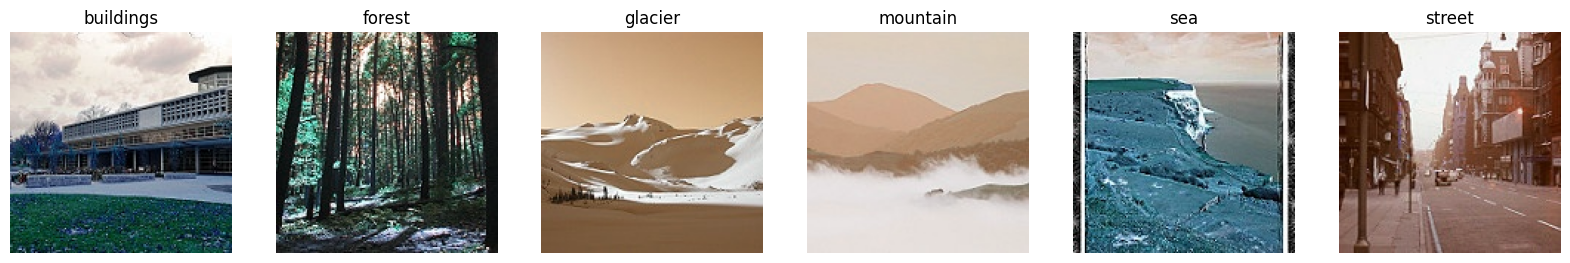

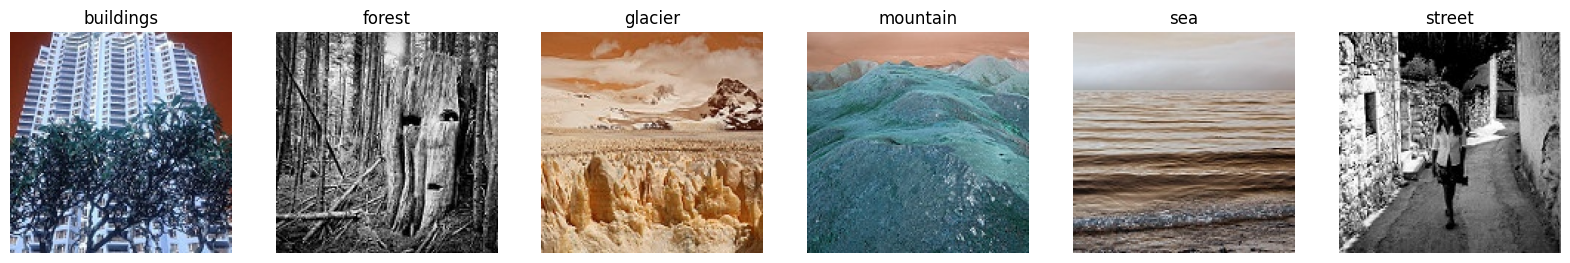

In [5]:
# display some images from the training data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_train[y_train == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

# display some images from the test data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_test[y_test == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

## Split Training and Validation Data

In [6]:
# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# split the training data into training and validation data
# 80% of the data will be used for training and 20% for validation
# split the data stratified by the labels
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Normalize Data

In [7]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## Model Architecture

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,328,262 (20.33 MB)

 Trainable params: 5,328,262 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [9]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
 10/351 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2331 - loss: 2.5363

I0000 00:00:1718655214.069023     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718655214.086332     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5319 - loss: 1.2302

W0000 00:00:1718655225.989809     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.5322 - loss: 1.2295 - val_accuracy: 0.7136 - val_loss: 0.7769
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7632 - loss: 0.6439 - val_accuracy: 0.7720 - val_loss: 0.6423
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8627 - loss: 0.3952 - val_accuracy: 0.7613 - val_loss: 0.6899
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9388 - loss: 0.1899 - val_accuracy: 0.7766 - val_loss: 0.8027
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9710 - loss: 0.0993 - val_accuracy: 0.7770 - val_loss: 0.9034
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9872 - loss: 0.0450 - val_accuracy: 0.7741 - val_loss: 1.0501
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9892 - loss: 0.0394 - val_accuracy: 0.7716 - val_loss: 1.1318
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9957 - loss: 0.0203 - val_accuracy: 0.7

In [10]:
# get the accuracy of the model

_, test_acc = model.evaluate(X_test, y_test, verbose=0)


print('Test accuracy:', test_acc)

Test accuracy: 0.765333354473114


## Save Model

In [11]:
model.save('cnn1.h5')

## Performance

### Accuracy and Loss

In [8]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train Accuracy")
    plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "Train Loss")
    plt.plot(history.history['val_loss'], label = "Validation Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

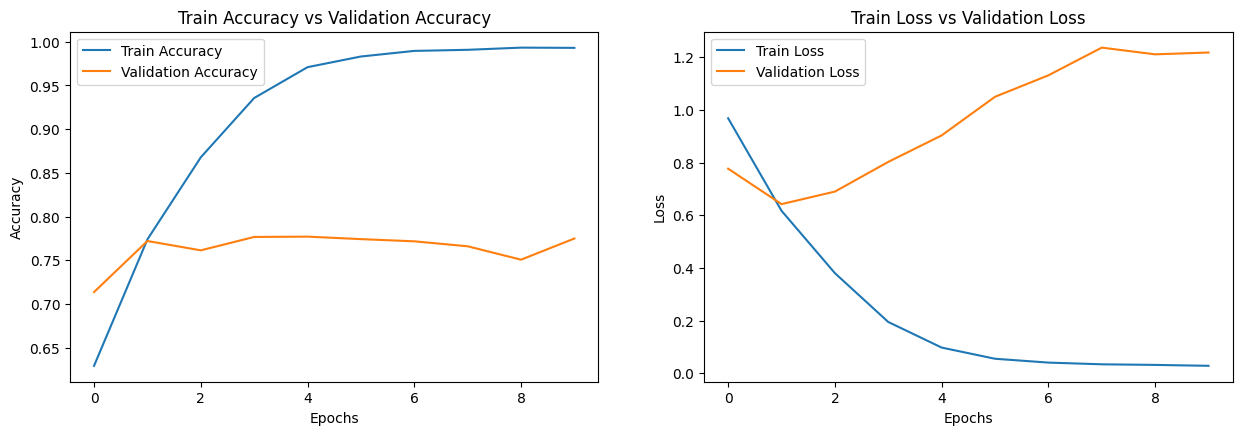

In [13]:
plot_accuracy_loss(history)

### Classification Report and Confusion Matrix

28/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

W0000 00:00:1718655317.621777     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       437
           1       0.91      0.96      0.93       474
           2       0.72      0.73      0.73       553
           3       0.77      0.70      0.73       525
           4       0.71      0.73      0.72       510
           5       0.79      0.76      0.77       501

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.76      3000



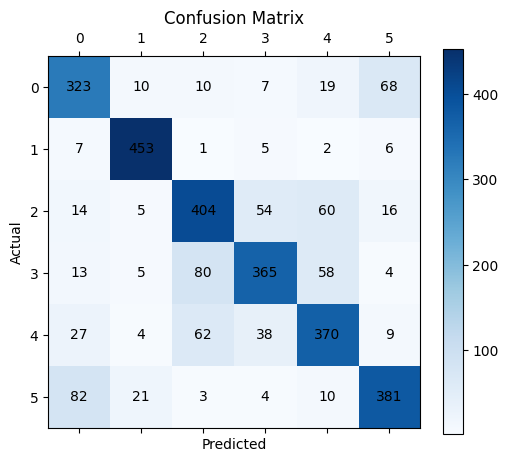

In [14]:
# Confusion Matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [15]:
print("Accuracy of the model using training data is - ", model.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9978 - loss: 0.0125
Accuracy of the model using training data is -  99.74169135093689 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7733 - loss: 1.1791
Accuracy of the model using validation data is -  77.48485803604126 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7852 - loss: 1.1931

Accuracy of the model is -  76.5333354473114 %


### ROC Curve

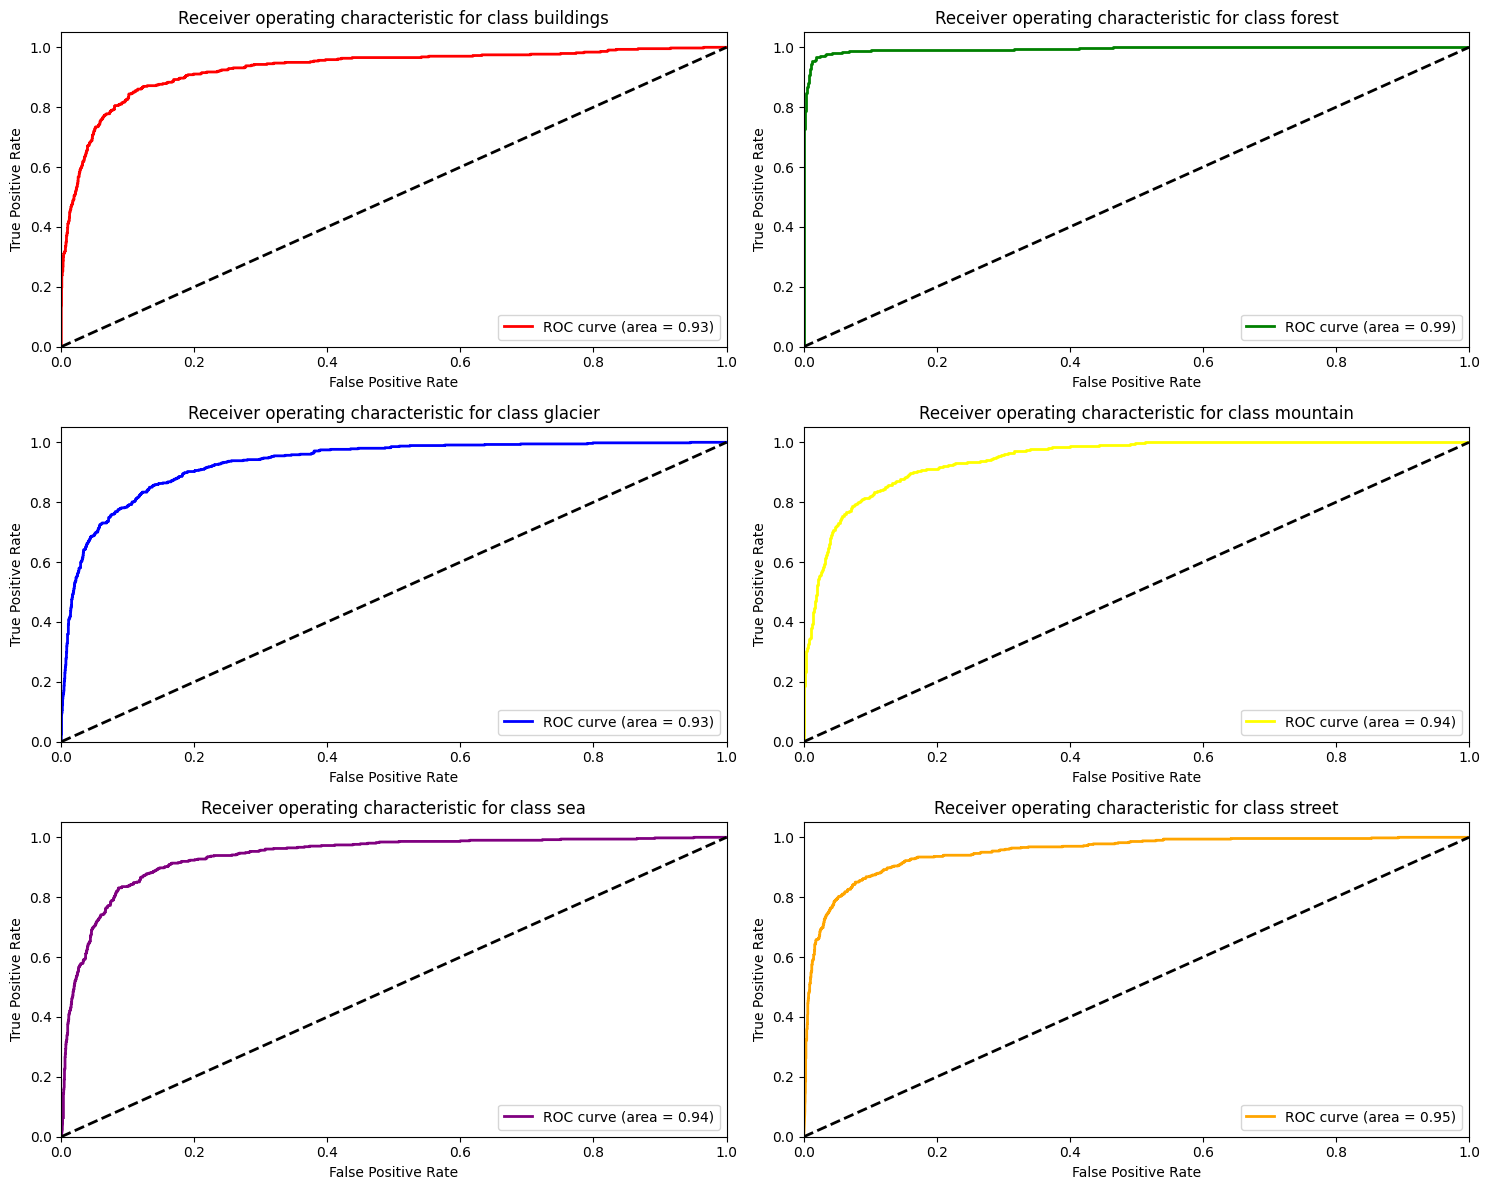

In [18]:
unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()

# Version 2

## Model Architecture

In [26]:
model = Sequential()

model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(150, 150, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 37, 37, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,758,886 (10.52 MB)

 Trainable params: 2,758,438 (10.52 MB)

 Non-trainable params: 448 (1.75 KB)

## Train Model

In [27]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[reduce_lr], verbose=2)

Epoch 1/30


W0000 00:00:1718655571.205428     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718655608.180863     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 - 55s - 157ms/step - accuracy: 0.5538 - loss: 1.4658 - val_accuracy: 0.3730 - val_loss: 3.0164 - learning_rate: 0.0010
Epoch 2/30
351/351 - 20s - 57ms/step - accuracy: 0.6600 - loss: 0.8988 - val_accuracy: 0.4827 - val_loss: 1.7704 - learning_rate: 0.0010
Epoch 3/30
351/351 - 20s - 57ms/step - accuracy: 0.7182 - loss: 0.7767 - val_accuracy: 0.4065 - val_loss: 2.5827 - learning_rate: 0.0010
Epoch 4/30
351/351 - 20s - 58ms/step - accuracy: 0.7518 - loss: 0.6797 - val_accuracy: 0.7271 - val_loss: 0.8322 - learning_rate: 0.0010
Epoch 5/30
351/351 - 20s - 56ms/step - accuracy: 0.7832 - loss: 0.5996 - val_accuracy: 0.5237 - val_loss: 2.5983 - learning_rate: 0.0010
Epoch 6/30
351/351 - 20s - 56ms/step - accuracy: 0.8107 - loss: 0.5186 - val_accuracy: 0.7588 - val_loss: 0.7151 - learning_rate: 0.0010
Epoch 7/30
351/351 - 20s - 56ms/step - accuracy: 0.8316 - loss: 0.4661 - val_accuracy: 0.3734 - val_loss: 4.2553 - learning_rate: 0.0010
Epoch 8/30
351/351 - 20s - 56ms/step - accuracy: 0.

In [28]:
# get the accuracy of the model
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.8476666808128357


W0000 00:00:1718656196.821801     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Save Model

In [29]:
model.save('cnn2.h5')

## Performance

### Accuracy and Loss

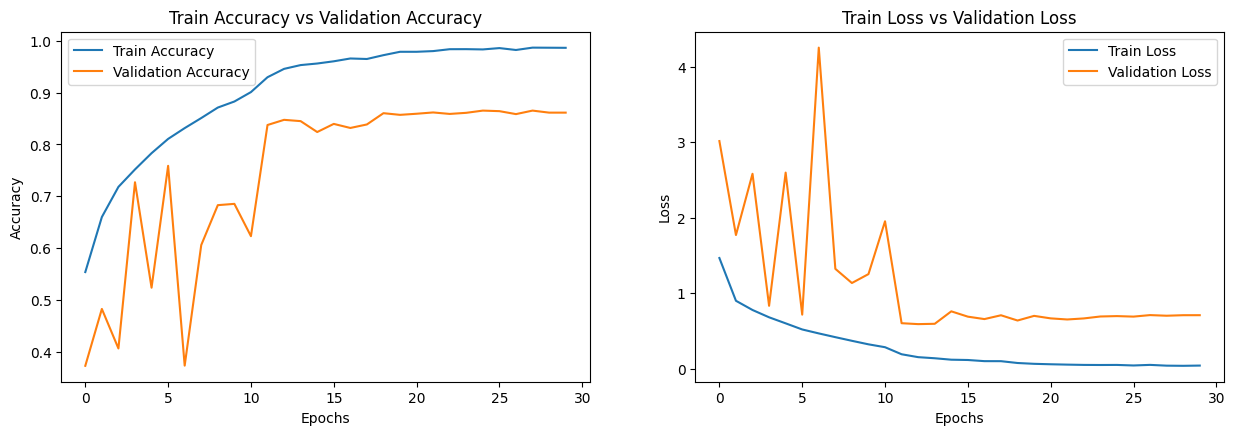

In [30]:
plot_accuracy_loss(history)

### Confusion Matrix and Classification Report

13/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

W0000 00:00:1718656214.626510     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


W0000 00:00:1718656216.142066     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.83      0.80      0.82       437
           1       0.95      0.98      0.97       474
           2       0.79      0.80      0.80       553
           3       0.79      0.81      0.80       525
           4       0.88      0.85      0.87       510
           5       0.85      0.86      0.85       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



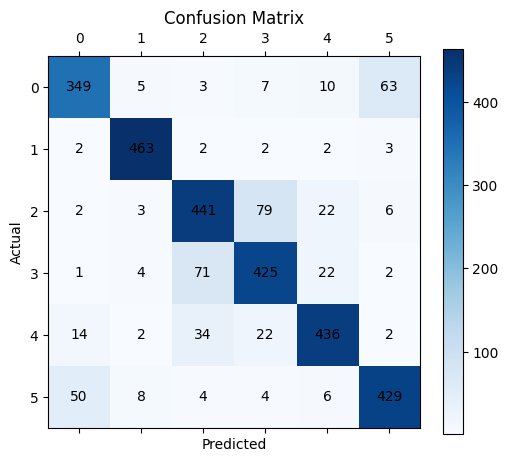

In [31]:
# Confusion Matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [32]:
print("Accuracy of the model using training data is - ", model.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9988 - loss: 0.0062
Accuracy of the model using training data is -  99.8485803604126 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8671 - loss: 0.6402
Accuracy of the model using validation data is -  86.14178895950317 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8430 - loss: 0.8086

Accuracy of the model is -  84.76666808128357 %


### ROC Curve

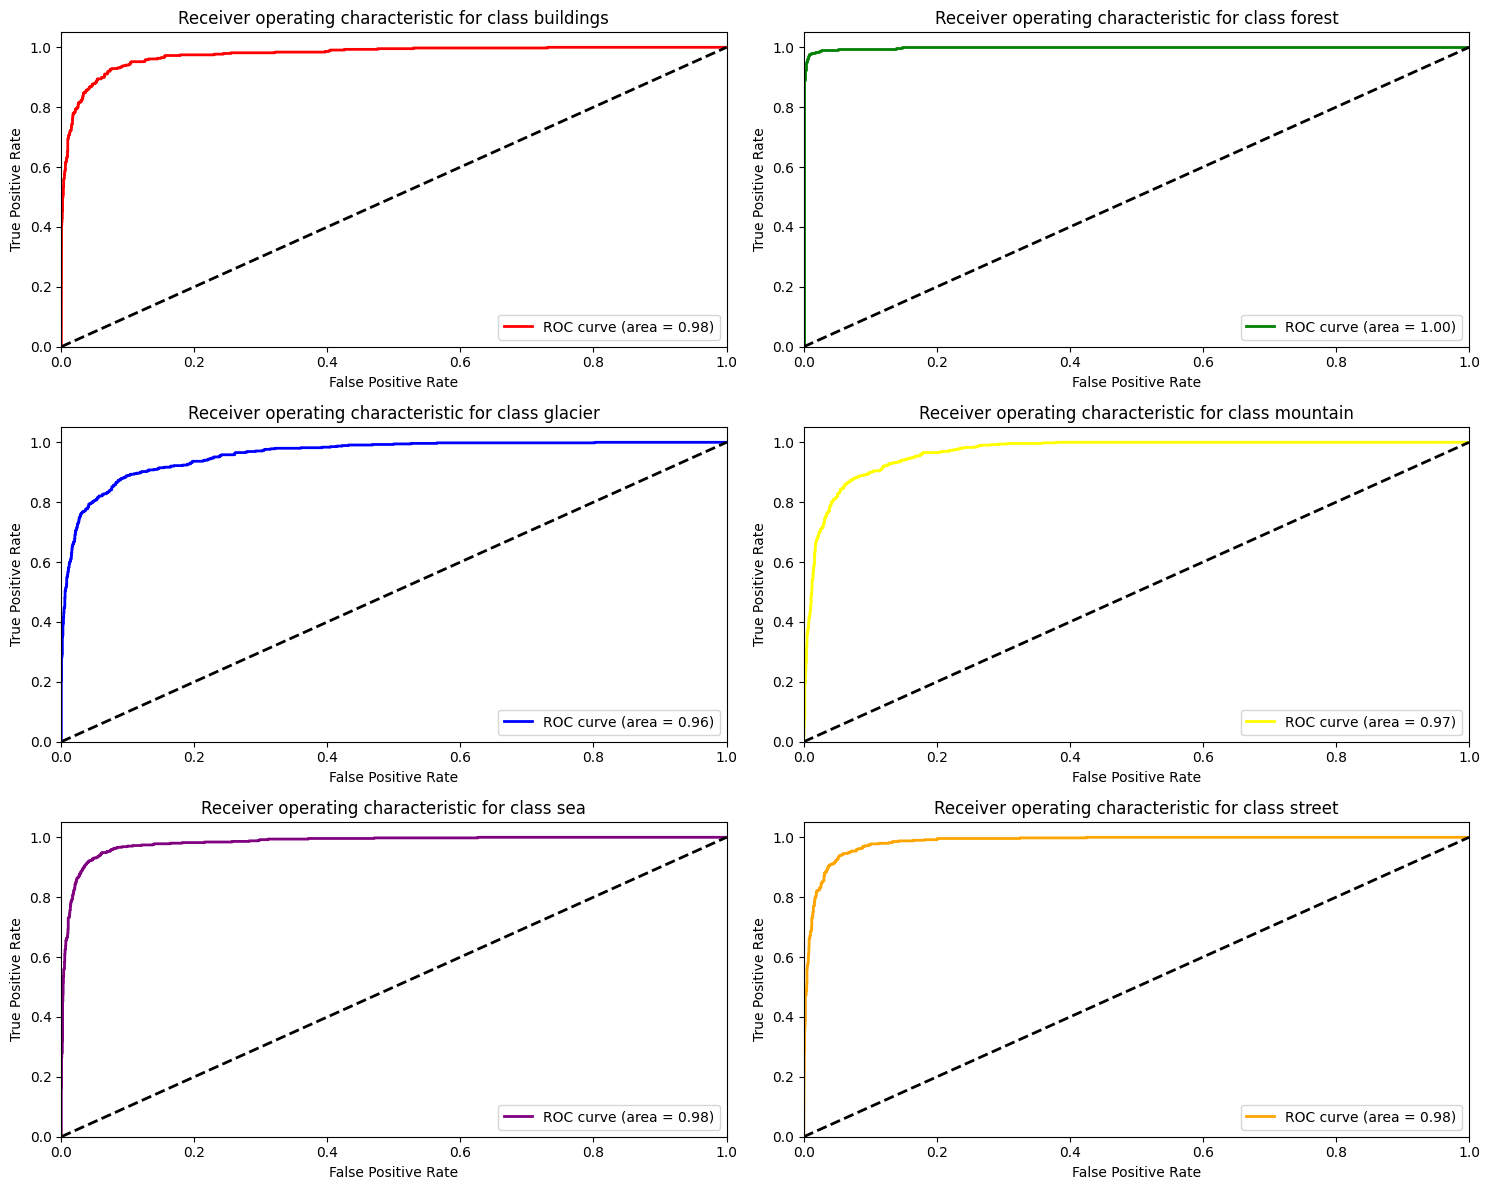

In [33]:
unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()

# Version 3

## Model Architecture

In [10]:
model = Sequential()

model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(150, 150, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(6, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 38, 38, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 38, 38, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 19, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11552)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     5,915,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,021,094 (22.97 MB)

 Trainable params: 6,020,646 (22.97 MB)

 Non-trainable params: 448 (1.75 KB)

## Train Model

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False # randomly flip images
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=30, validation_data=(X_val, y_val), callbacks=[reduce_lr])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/176 ━━━━━━━━━━━━━━━━━━━━ 1:11:42 25s/step - accuracy: 0.1719 - loss: 3.0948

I0000 00:00:1718657646.274092     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718657646.293232     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/176 ━━━━━━━━━━━━━━━━━━━━ 3:52 1s/step - accuracy: 0.3427 - loss: 6.6489  

W0000 00:00:1718657666.557601     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5050 - loss: 2.7091

W0000 00:00:1718657717.552633     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 431ms/step - accuracy: 0.5053 - loss: 2.7027 - val_accuracy: 0.1628 - val_loss: 7.2601 - learning_rate: 0.0010
Epoch 2/30


W0000 00:00:1718657721.883371     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 287ms/step - accuracy: 0.6427 - loss: 0.9463 - val_accuracy: 0.5843 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 294ms/step - accuracy: 0.6893 - loss: 0.8433 - val_accuracy: 0.4838 - val_loss: 2.1718 - learning_rate: 0.0010
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.7339 - loss: 0.7278
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 294ms/step - accuracy: 0.7339 - loss: 0.7277 - val_accuracy: 0.5105 - val_loss: 1.8241 - learning_rate: 0.0010
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 289ms/step - accuracy: 0.7766 - loss: 0.6070 - val_accuracy: 0.7442 - val_loss: 0.9082 - learning_rate: 5.0000e-04
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 289ms/step - accuracy: 0.7997 - loss: 0.5566 - val_accuracy: 0.6744 - val_loss: 1.2014 - learning_rate: 5.0000e-04
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 289ms/step - accuracy: 0.8001 -

In [12]:
# get the accuracy of the model
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.862666666507721


W0000 00:00:1718659262.142867     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Save Model

In [13]:
model.save('cnn3.h5')

## Performance

### Accuracy and Loss

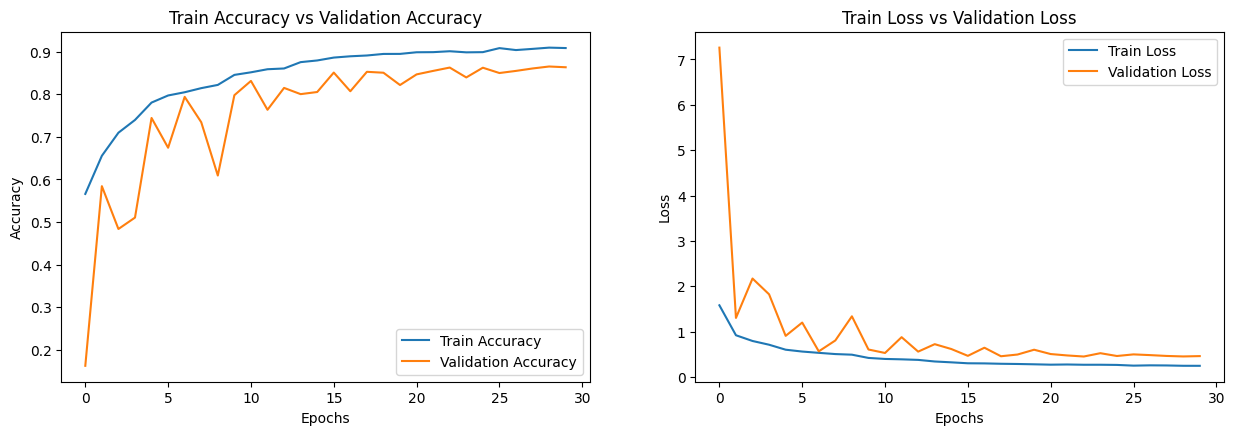

In [14]:
plot_accuracy_loss(history)

### Confusion Matrix and Classification Report

13/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

W0000 00:00:1718659265.416254     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


W0000 00:00:1718659267.035856     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.85      0.84      0.84       437
           1       0.92      0.98      0.95       474
           2       0.84      0.80      0.82       553
           3       0.83      0.80      0.82       525
           4       0.85      0.91      0.88       510
           5       0.90      0.84      0.87       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



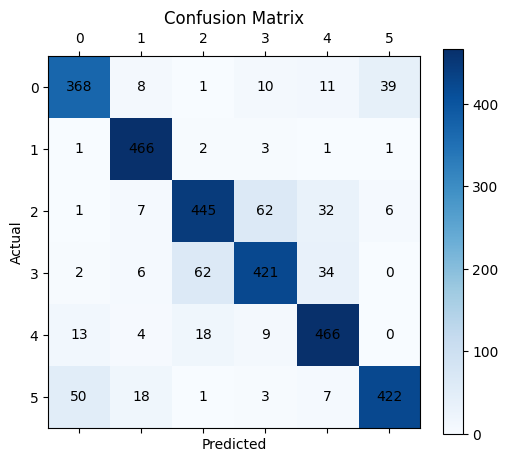

In [15]:
# Confusion Matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [16]:
print("Accuracy of the model using training data is - ", model.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9316 - loss: 0.1883


W0000 00:00:1718659282.351802     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of the model using training data is -  92.85650849342346 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8682 - loss: 0.4433
Accuracy of the model using validation data is -  86.31991744041443 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8663 - loss: 0.4355

Accuracy of the model is -  86.2666666507721 %


### ROC Curve

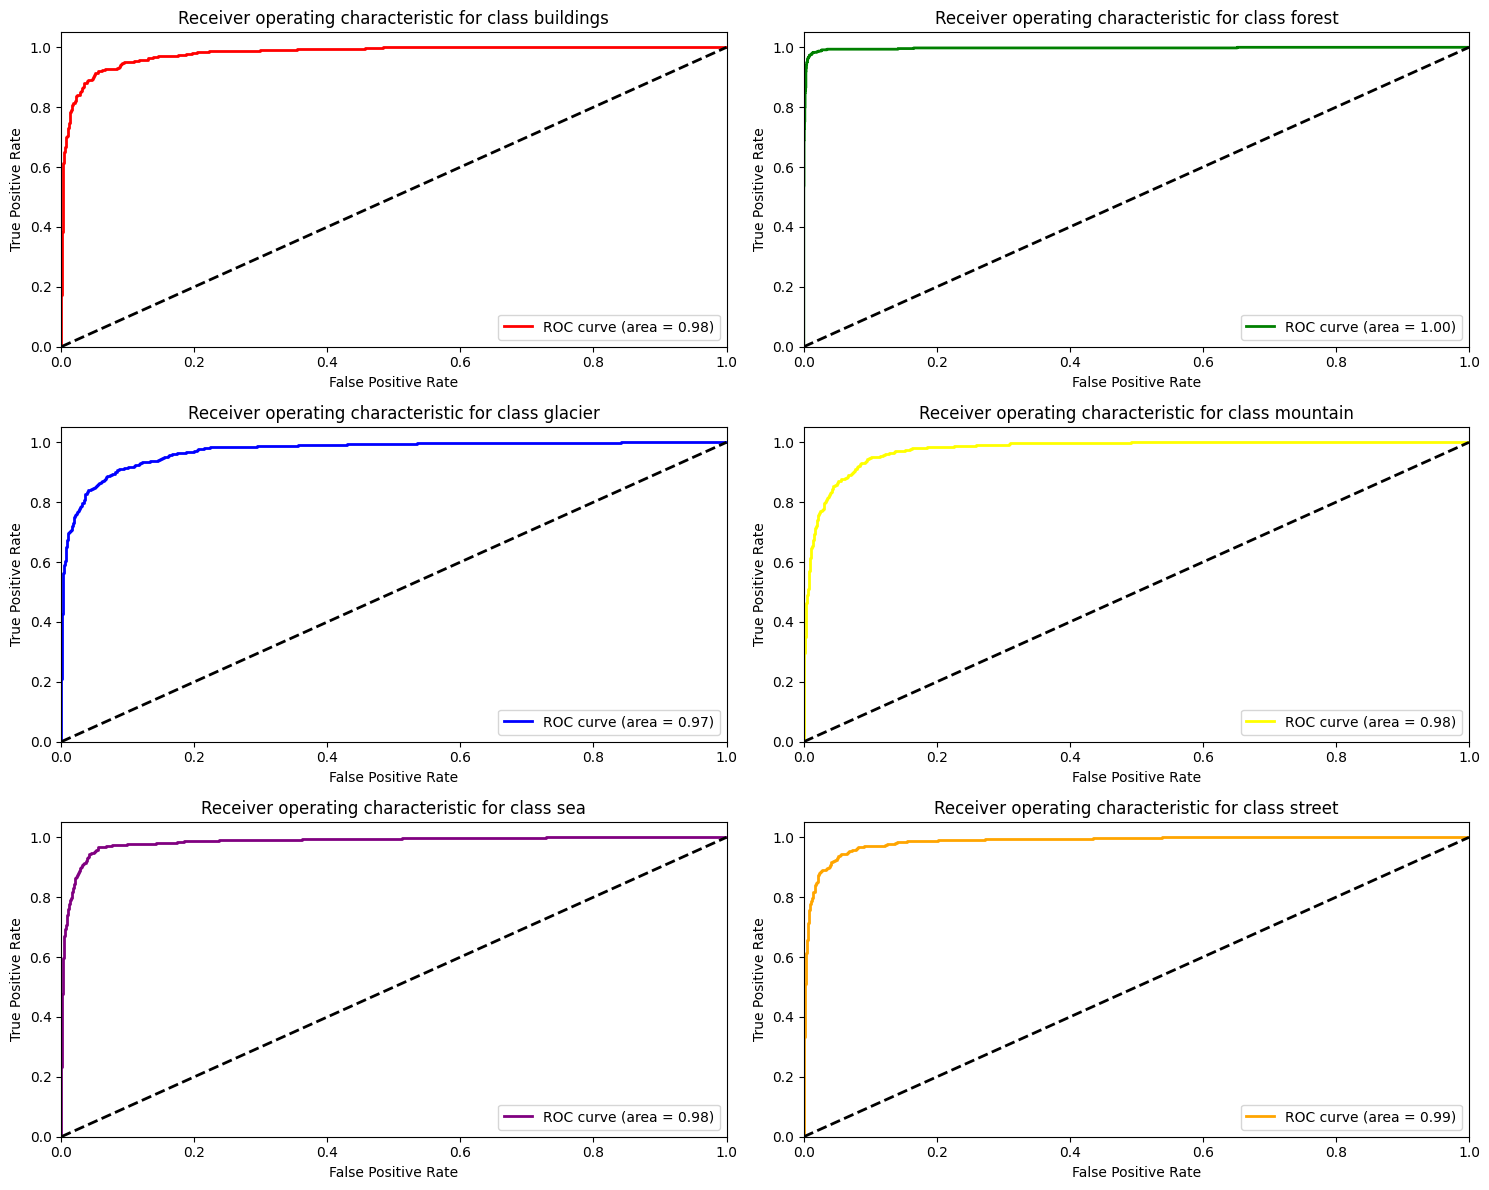

In [17]:
unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()